# Analysis to identify the best locations for new coffee shops in Central London zones 1 to 3

## 3 data sources will be used:
## - List of tube stations and their geolocation
## - List of tube passenger number data
## - Foursquare API to obtain nearby venue types

In [1]:
import pandas as pd
import numpy as np

## Scrape London tube station data into Pandas dataframe

In [2]:
#download table and store as data frame
url = 'https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/Tables'
dfs = pd.read_html(url)
df = dfs[0]

df.head()

,id,latitude,longitude,name,display_name,zone,total_lines,rail
0,1,51.5028,-0.2801,Acton Town,Acton<br />Town,3.0,3,0
1,2,51.5143,-0.0755,Aldgate,NaN,1.0,2,0
2,3,51.5154,-0.0726,Aldgate East,Aldgate<br />East,1.0,2,0
3,4,51.5107,-0.0130,All Saints,All<br />Saints,2.0,1,0
4,5,51.5407,-0.2997,Alperton,NaN,4.0,1,0


In [3]:
df.drop('display_name', axis=1, inplace=True)

df.rename(columns={'name':'tube name'}, 
                 inplace=True)

df.head()

,id,latitude,longitude,tube name,zone,total_lines,rail
0,1,51.5028,-0.2801,Acton Town,3.0,3,0
1,2,51.5143,-0.0755,Aldgate,1.0,2,0
2,3,51.5154,-0.0726,Aldgate East,1.0,2,0
3,4,51.5107,-0.0130,All Saints,2.0,1,0
4,5,51.5407,-0.2997,Alperton,4.0,1,0


## Limit analysis to tube station zones 1 to 3

In [4]:
df = df.drop(df[(df.zone > 3)].index)

print(df.head())
print(df.shape)

   id  latitude  longitude     tube name  zone  total_lines  rail
0   1   51.5028    -0.2801    Acton Town   3.0            3     0
1   2   51.5143    -0.0755       Aldgate   1.0            2     0
2   3   51.5154    -0.0726  Aldgate East   1.0            2     0
3   4   51.5107    -0.0130    All Saints   2.0            1     0
5   7   51.5322    -0.1058         Angel   1.0            1     0
(207, 7)


## Initialize map

In [5]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import json
import requests
from pandas.io.json import json_normalize

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

## Plot zone 1 to 3 tube stations on map of London

In [93]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="DG on Coursera")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London, United Kingdom are {}, {}.'.format(latitude, longitude))

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, zone in zip(df['latitude'], df['longitude'], df['tube name'], df['zone']):
    label = '{}, zone {}'.format(name, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

The geograpical coordinate of London, United Kingdom are 51.5073219, -0.1276474.


In [9]:
# The code was removed by Watson Studio for sharing.

## Obtain list of venues in close proximity to each tube station

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['tube name', 
                  'tube latitude', 
                  'tube longitude', 
                  'venue', 
                  'venue latitude', 
                  'venue longitude', 
                  'venue category']
    
    return(nearby_venues)

In [11]:
#toronto_neighborhoods = toronto_data
nearby_venues = getNearbyVenues(names=df['tube name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

Acton Town
Aldgate
Aldgate East
All Saints
Angel
Archway
Arsenal
Baker Street
Balham
Bank
Barbican
Barons Court
Bayswater
Beckton
Beckton Park
Belsize Park
Bethnal Green
Blackfriars
Blackhorse Road
Blackwall
Bond Street
Borough
Bow Church
Bow Road
Brent Cross
Bromley-By-Bow
Caledonian Road
Camden Town
Canary Wharf
Cannon Street
Chalk Farm
Chancery Lane
Charing Cross
Chiswick Park
Clapham Common
Clapham North
Clapham South
Colliers Wood
Covent Garden
Crossharbour & London Arena
Custom House
Cyprus
Devons Road
Dollis Hill
Ealing Broadway
Ealing Common
Earl's Court
East Acton
East Finchley
East India
East Putney
Edgware Road (B)
Edgware Road (C)
Elephant & Castle
Embankment
Euston
Euston Square
Farringdon
Finchley Road
Finsbury Park
Fulham Broadway
Gallions Reach
Gloucester Road
Golders Green
Goldhawk Road
Goodge Street
Great Portland Street
Green Park
Gunnersbury
Hammersmith
Hampstead
Hanger Lane
Harlesden
Heron Quays
High Street Kensington
Highbury & Islington
Highgate
Holborn
Holland P

In [12]:
nearby_venues.shape

(10478, 7)

In [13]:
nearby_venues.head()

,tube name,tube latitude,tube longitude,venue,venue latitude,venue longitude,venue category
0,Acton Town,51.5028,-0.2801,The Apple Tree Cakes,51.503174,-0.280474,Coffee Shop
1,Acton Town,51.5028,-0.2801,WP Fish X Chips,51.502580,-0.281240,Fish & Chips Shop
2,Acton Town,51.5028,-0.2801,London Transport Museum Depot,51.504175,-0.280622,Museum
3,Acton Town,51.5028,-0.2801,Jungles Cafe,51.503272,-0.280173,Breakfast Spot
4,Acton Town,51.5028,-0.2801,M&S Simply Food,51.501229,-0.280420,Grocery Store


## Convert tube, venue table to onehot table

In [14]:
# one hot encoding
london_onehot = pd.get_dummies(nearby_venues[['venue category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['tube name'] = nearby_venues['tube name'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.shape

(10478, 391)

In [44]:
london_onehot.head()

,tube name,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Acton Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acton Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acton Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acton Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acton Town,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate the proportions of different venue types in each location

In [15]:
london_grouped = london_onehot.groupby('tube name').mean().reset_index()
london_grouped

,tube name,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,Acton Town,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047619,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
1,Aldgate,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.000000,0.000000,0.0
2,Aldgate East,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.010000,0.000000,0.00,0.01,0.010000,0.000000,0.0
3,All Saints,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
4,Angel,0.000000,0.0,0.012346,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.012346,0.0
5,Archway,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
6,Arsenal,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
7,Baker Street,0.010309,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.020619,0.000000,0.0
8,Balham,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.016129,0.0
9,Bank,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.000000,0.010000,0.0


## Create new data frame showing the saturation of coffee shops

In [16]:
df_coffee = london_grouped[['tube name','Coffee Shop']].copy()
df_coffee

,tube name,Coffee Shop
0,Acton Town,0.047619
1,Aldgate,0.120000
2,Aldgate East,0.110000
3,All Saints,0.076923
4,Angel,0.074074
5,Archway,0.171429
6,Arsenal,0.000000
7,Baker Street,0.051546
8,Balham,0.145161
9,Bank,0.110000


## Sort coffee percentage in ascending order to see biggest opportunity 

In [17]:
df_coffee.sort_values(['Coffee Shop', 'tube name'], ascending=[1, 0])

,tube name,Coffee Shop
205,Wimbledon Park,0.000000
197,Westbourne Park,0.000000
196,West Silvertown,0.000000
192,West Ham,0.000000
191,West Brompton,0.000000
190,West Acton,0.000000
183,Vauxhall,0.000000
182,Upton Park,0.000000
168,Stonebridge Park,0.000000
166,Stepney Green,0.000000


## create shortlist

In [18]:
df_coffee.rename(columns={'Coffee Shop':'coffee_shop'}, 
                 inplace=True)

In [19]:
df_coffee_shortlist = df_coffee.drop(df_coffee[(df_coffee.coffee_shop > 0)].index)
df_coffee_shortlist.size

74

## We now have a shortlist of store locations. We can use the station traffic data to find the shortlisted location that will have the highest footfall

In [20]:
url = 'https://data.london.gov.uk/download/london-underground-performance-reports/b6ab04fc-9062-4291-b514-7fa218073b4c/multi-year-station-entry-and-exit-figures.xls'
df_station_traffic = pd.read_excel(url, sheet_name='2017 Entry & Exit', header=6)
df_station_traffic.head()

,nlc,Station,Borough,Note,Weekday,Saturday,Sunday,Weekday.1,Saturday.1,Sunday.1,million
0,500.0,Acton Town,Ealing,,9531.0,6716.0,4744.0,9382.0,6617.0,4785.0,6.040516
1,502.0,Aldgate,City of London,,15080.0,4397.0,3261.0,16023.0,5909.0,4230.0,8.846940
2,503.0,Aldgate East,Tower Hamlets,,22327.0,16166.0,13323.0,21071.0,13893.0,11347.0,13.998292
3,505.0,Alperton,Brent,,4495.0,3279.0,2345.0,5081.0,3392.0,2445.0,3.052230
4,506.0,Amersham,Chiltern,,3848.0,1876.0,1232.0,4025.0,1797.0,1121.0,2.321692


In [21]:
df_station_traffic.rename(columns={'Station':'tube name'}, 
                 inplace=True)

In [22]:
df_station_traffic.drop(['nlc', 'Borough', 'Note', 'Weekday', 'Saturday','Sunday','Weekday.1','Saturday.1','Sunday.1'], axis=1, inplace=True)
df_station_traffic.head()

,tube name,million
0,Acton Town,6.040516
1,Aldgate,8.846940
2,Aldgate East,13.998292
3,Alperton,3.052230
4,Amersham,2.321692


## merge coffee shop and tube passenger data

In [23]:
tube_merged = df_coffee_shortlist.join(df_station_traffic.set_index('tube name'), on='tube name')

In [84]:
tube_merged.head()

,tube name,coffee_shop,million
6,Arsenal,0.0,2.822292
13,Beckton,0.0,NaN
14,Beckton Park,0.0,NaN
19,Blackhorse Road,0.0,8.999728
27,Bromley-By-Bow,0.0,NaN


## clean data - remove stations for which we don't have passenger data

In [24]:
tube_merged.dropna(inplace=True)

In [25]:
tube_merged.sort_values(['million', 'tube name'], ascending=[0, 1], inplace=True)

## Show the top 10 potential store locations

In [26]:
tube_merged.head(10)

,tube name,coffee_shop,million
74,Green Park,0.0,39.338161
183,Vauxhall,0.0,30.833904
135,Pimlico,0.0,10.971039
182,Upton Park,0.0,9.593829
19,Blackhorse Road,0.0,8.999728
111,Manor House,0.0,8.688099
166,Stepney Green,0.0,6.341140
136,Plaistow,0.0,6.128691
191,West Brompton,0.0,5.877152
84,Highgate,0.0,5.873629


In [27]:
tube_merged = (tube_merged[:10])

## re-apply location data

In [28]:
tube_merged = tube_merged.join(df.set_index('tube name'), on='tube name')

In [29]:
tube_merged.head()

,tube name,coffee_shop,million,id,latitude,longitude,zone,total_lines,rail
74,Green Park,0.0,39.338161,107,51.5067,-0.1428,1.0,3,0
183,Vauxhall,0.0,30.833904,272,51.4861,-0.1253,1.5,1,1
135,Pimlico,0.0,10.971039,198,51.4893,-0.1334,1.0,1,0
182,Upton Park,0.0,9.593829,270,51.5352,0.0343,3.0,2,0
19,Blackhorse Road,0.0,8.999728,26,51.5867,-0.0417,3.0,1,1


## new map of top 10 ideal store locations

In [94]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="DG on Coursera")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London, United Kingdom are {}, {}.'.format(latitude, longitude))

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name, zone in zip(tube_merged['latitude'], tube_merged['longitude'], tube_merged['tube name'], tube_merged['zone']):
    label = '{}, zone {}'.format(name, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

The geograpical coordinate of London, United Kingdom are 51.5073219, -0.1276474.


## Next we will show a bar chart showing the potential footfall of each location

In [32]:
import numpy as np
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.2


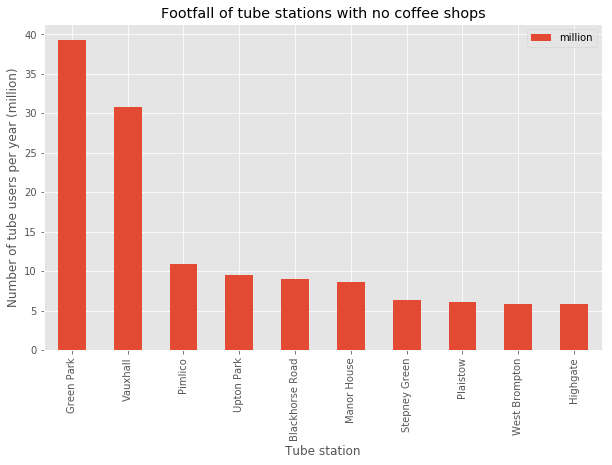

In [33]:
chart_data = tube_merged.drop(['coffee_shop', 'id', 'latitude', 'longitude', 'zone', 'total_lines', 'rail'], axis=1)
chart_data.set_index('tube name', drop=True, append=False, inplace=True, verify_integrity=False)
chart_data.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Tube station') # add to x-label to the plot
plt.ylabel('Number of tube users per year (million)') # add y-label to the plot
plt.title('Footfall of tube stations with no coffee shops') # add title to the plot

plt.show()

## Green Park has been identified as an ideal location for a coffee shop. We will use k-means clustering to find all of the other stations that have similar characteristics to Green Park

In [34]:
#return to analysis of one hot table

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
london_grouped

,tube name,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,...,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,Acton Town,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.047619,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
1,Aldgate,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.010000,0.00,0.00,0.000000,0.000000,0.0
2,Aldgate East,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.010000,0.000000,0.00,0.01,0.010000,0.000000,0.0
3,All Saints,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
4,Angel,0.000000,0.0,0.012346,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.012346,0.0
5,Archway,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
6,Arsenal,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0
7,Baker Street,0.010309,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.020619,0.000000,0.0
8,Balham,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.016129,0.0
9,Bank,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.020000,0.000000,0.00,0.00,0.000000,0.010000,0.0


In [68]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['tube name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tube_venues_sorted = pd.DataFrame(columns=columns)
tube_venues_sorted['tube name'] = london_grouped['tube name']

for ind in np.arange(london_grouped.shape[0]):
    tube_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

tube_venues_sorted.head()

,tube name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton Town,Platform,Hotel,Pub,Deli / Bodega,Metro Station,Grocery Store,Fast Food Restaurant,Coffee Shop,Auto Garage,Café
1,Aldgate,Coffee Shop,Hotel,Pub,Indian Restaurant,Cocktail Bar,Sushi Restaurant,Thai Restaurant,Gym / Fitness Center,Japanese Restaurant,Salad Place
2,Aldgate East,Coffee Shop,Hotel,Pub,Pizza Place,Cocktail Bar,Café,Thai Restaurant,Indian Restaurant,Gym / Fitness Center,Japanese Restaurant
3,All Saints,Intersection,Hotel,Park,English Restaurant,Chinese Restaurant,Tunnel,Café,Coffee Shop,Grocery Store,Pizza Place
4,Angel,Pub,Coffee Shop,Hotel,Gym / Fitness Center,Café,French Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Burger Joint,Burrito Place


## Cluster the tube stations with k-means

In [39]:
from sklearn.cluster import KMeans

In [69]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('tube name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
tube_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tube_venues_sorted.head()

,Cluster Labels,tube name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,3,Acton Town,Platform,Hotel,Pub,Deli / Bodega,Metro Station,Grocery Store,Fast Food Restaurant,Coffee Shop,Auto Garage,Café
1,0,Aldgate,Coffee Shop,Hotel,Pub,Indian Restaurant,Cocktail Bar,Sushi Restaurant,Thai Restaurant,Gym / Fitness Center,Japanese Restaurant,Salad Place
2,0,Aldgate East,Coffee Shop,Hotel,Pub,Pizza Place,Cocktail Bar,Café,Thai Restaurant,Indian Restaurant,Gym / Fitness Center,Japanese Restaurant
3,4,All Saints,Intersection,Hotel,Park,English Restaurant,Chinese Restaurant,Tunnel,Café,Coffee Shop,Grocery Store,Pizza Place
4,0,Angel,Pub,Coffee Shop,Hotel,Gym / Fitness Center,Café,French Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Burger Joint,Burrito Place


## Obtain cluster value of Green Park then filter dataframe for all stations within the same cluster

In [72]:
tube_venues_sorted.loc[tube_venues_sorted['tube name'] == 'Green Park', 'Cluster Labels'].values[0]

0

In [91]:
tube_venues_sorted.rename(columns={'Cluster Labels':'cluster_labels'}, 
                 inplace=True)

df_tube_shortlist = tube_venues_sorted.join(df.set_index('tube name'), on='tube name')
df_tube_shortlist = df_tube_shortlist.drop(df_tube_shortlist[(df_tube_shortlist.cluster_labels != 0)].index)

df_tube_shortlist.shape

(90, 18)

## Plot new map

In [95]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="DG on Coursera")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London, United Kingdom are {}, {}.'.format(latitude, longitude))

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name, zone in zip(df_tube_shortlist['latitude'], df_tube_shortlist['longitude'], df_tube_shortlist['tube name'], df_tube_shortlist['zone']):
    label = '{}, zone {}'.format(name, zone)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

The geograpical coordinate of London, United Kingdom are 51.5073219, -0.1276474.


## The research concludes that Green Park is one of the most ideal locations for a new coffee shop. Taking into account the characteristics of Green Park, 90 tube stations are within the same cluster so are also potential candidates for a new shop.

## However, the Foursquare coffee shop location data appears to be incomplete, so an analysis should be carried out using a different API data source such as Google Maps.